In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (ScalarOutcome, Policy)

# 3. Directed Search: MORDM Uncertainty analysis

In this notebook the five candidate solutions provide by the MOEA algorithm are tested on their performance under different uncertainty levels. Each policy was evaluated under 10.000 scenarios in 3_MORDM_uncertainty.py. The results were saved in a CSV file.

This notebook applies two metrics to identify the level of robustness of the policies; the Signal-to-Noise ratio and the Maximum regret value. The Signal-to_Noise ratio determines how strong the signal of a policy is in comparison to the background noise under different scenarios. In this case the signal can be seen as the preferred outcomes while the noise would indicate the various external effects and unintended consequences. Maximum regret relates to the maximum amount of regret that is created when a policy in a new scenario is compared to a reference scenario. The outcome of this metric is preferred to be as low as possible.

This notebook has the following structure:
1. Importing generated files

Description of the uncertainty analysis can be found in chapter 3.2.3 of the report.

In [2]:
# Import the dike_model
from problem_formulation import get_model_for_problem_formulation

# Define model
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
policies = pd.read_csv('data/output_data/MOEA_selected_policies.csv')
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [4]:
#Import of the csv files from the previous MORDM step
uncertainty_outcomes = pd.read_csv('data/output_data/MOEA_uncertainty_outcomes.csv')
uncertainty_experiments = pd.read_csv('data/output_data/MOEA_uncertainty_experiments.csv')

In [5]:
#uncertainty_outcomes = uncertainty_outcomes.drop(columns='Unnamed: 0')
uncertainty_outcomes

,Unnamed: 0,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
0,0,2.905471e+06,5.915904e+08,151900000.0,297.737877,0.000271,0
1,1,0.000000e+00,5.915904e+08,151900000.0,0.000000,0.000000,0
2,2,4.675528e+05,5.915904e+08,151900000.0,43.651835,0.000048,0
3,3,0.000000e+00,5.915904e+08,151900000.0,0.000000,0.000000,0
4,4,1.251384e+07,5.915904e+08,151900000.0,898.634622,0.000688,0
...,...,...,...,...,...,...,...
49995,49995,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49996,49996,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49997,49997,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4
49998,49998,0.000000e+00,4.853358e+08,182600000.0,0.000000,0.000000,4


In [6]:
uncertainty_experiments

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,73,237.223619,10.0,0.822949,257.939688,1.0,0.503687,191.079508,10.0,...,7,3,4,2,10,3,3,0,0,dikesnet
1,1,100,217.582195,1.0,0.605151,247.388211,1.0,0.312620,53.665794,1.0,...,7,3,4,2,10,3,3,1,0,dikesnet
2,2,102,330.365728,10.0,0.536505,199.599995,10.0,0.796105,290.208831,1.5,...,7,3,4,2,10,3,3,2,0,dikesnet
3,3,38,198.899576,10.0,0.863812,67.180982,1.0,0.254501,199.763387,1.0,...,7,3,4,2,10,3,3,3,0,dikesnet
4,4,95,259.903908,1.5,0.430111,116.302986,1.5,0.715382,258.385764,1.0,...,7,3,4,2,10,3,3,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,25,333.392351,1.5,0.182541,200.358237,10.0,0.491426,181.191046,10.0,...,0,6,3,5,10,0,0,9995,4,dikesnet
49996,49996,36,83.039895,1.0,0.946074,49.079330,1.5,0.391886,226.166062,1.5,...,0,6,3,5,10,0,0,9996,4,dikesnet
49997,49997,35,331.179930,1.0,0.183885,123.736414,10.0,0.144689,104.541520,1.5,...,0,6,3,5,10,0,0,9997,4,dikesnet
49998,49998,42,223.895330,1.0,0.887494,211.866952,1.0,0.594167,331.685061,10.0,...,0,6,3,5,10,0,0,9998,4,dikesnet


## 1. Signal-to-noise ratio

The Signal-to-noise ratio is executed in three steps. First the definition on how to calculate the Signal-to-noise ratio is given. Next, the Signal-to noise ratio is calculated for every unique policy of which the data is stored in the correct data frame form. Lastly, this data is used to determine the limits of the results and to visualize the outcomes.

In the first step the calculation on how to determine the Signal-to-noise ratio is formed. Depending on direction of the preferred outcome the Signal-to-noise ratio is either the mean divided by the standard deviation or the mean multiplied by the standard deviation. The preference of the outcome objectives dictates whether Signal-to-noise ratio is desired to be maximized or minimized. In this case it is favored that the outcomes of the objectives are as low as possible. Therefore, the focus will lie on a minimized Signal-to-noise ratio.


In [7]:
#Definition is created on how to calculate the Signal-to-Noise ratio
data = uncertainty_outcomes.loc[:,[o.name for o in dike_model.outcomes]]

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

#The Signal-to-noise ratio is calculated based upon the direction of each policy.
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

The second step in the process executes the defined method of calculating the Signal-to-Noise ratio and saves the data in a new dataframe. First, the code iterates over every unique policy in the experiments. The next iteration is on the outcomes in which the outcome is pulled for the current policy. These outcomes are used to calculate the Signal-to-noise ratio by utilizing the definition in the previous cell. In the last step these Signal-to-noise results are stored in the "scores" dictionary and later added to the "overall-scores" dictionary. Finally these results are converted to a data frame and used in the next step.

In [8]:
overall_scores = {}

for policy in np.unique(uncertainty_experiments['policy']):
    scores = {}

    logical = uncertainty_experiments['policy']==policy

    for outcome in dike_model.outcomes:
        value  = uncertainty_outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.758945e+16,70.523070,0.0,4.374158e+06,0.000190
1,2.982867e+15,46.705509,0.0,7.586682e+05,0.000021
2,1.215021e+15,26.212740,0.0,4.338612e+05,0.000011
3,7.568295e+14,0.000000,0.0,6.140729e+04,0.000052
4,9.402667e+15,57.856532,0.0,9.454624e+05,0.000103


The final step of the Signal-to-noise calculation focuses on the visualization of the results. For this purpose the parcoords method is used and imported from the EMA workbench. As a first step the scores data frame is renamed to "data". In a next step the limits of the results for each column are determined and the lower bound of the results is set to zero. Then the data with the limits is plotted using the parcoords method. The axis of the expected annual damage is inverted to visualize the limits for this outcome.

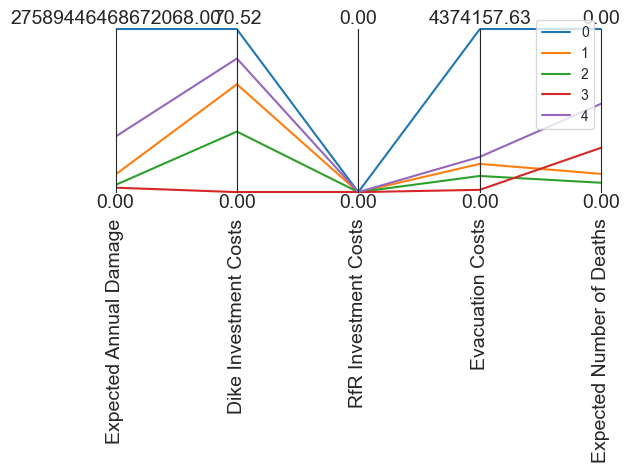

In [20]:
from ema_workbench.analysis import parcoords

#The data frame is renamed and the result limits are determined for the visualization.
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0

#The data is being plotted in a paracoords graph
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#Swapped axis eruit
#paraxes.invert_axis('Expected Annual Damage')
plt.legend(data.index)
plt.show()

The figure above indicates that none of the 5 policies are robust relating to the preferred objectives. In the ideal case all the coloured lines would cross the vertical lines on the lowest point which would indicate a low Signal-to-noise ratio.As none of all the lines relate to the preferred case trade-offs between the outcomes have to be made.

It is seen that for all policies the Room for River (RfR) investment is zero. This is because the RfR investment is a decision variable that is independent of external uncertainties. This indicates that this variable can influence the other variables while remaining unaffected by other variables.

Furthermore, it is clear that policy 0 has the worst Signal-to-noise ratios as it has the highest value for all objectives in comparison to the other policies. On the other hand, policy 3 scores very well with the lowest score for almost all objectives. It only scores relatively high for the Expected number of deaths. This results in a trade-off between the height of the Evacuation costs and the Expected number of deaths.


## 2. Maximum regret

The maximum regret value provides another metric to determine the robustness of a policy. First the regret for each single policy needs to be tested under each scenario. The definition of regret is the difference in performance of a policy between a specific scenario and a reference scenario. The maximum height of this regret is than named as the maximum regret and is preferred to be as low as possible.

In this case we are solely dealing with outcomes that are preferred to be minimized which makes the comparison of the results simple. However, when the direction of an objective is changed the comparison cannot be made anymore. To avoid this problem the absolute value is taken for the regret values so that it is possible to analyse the results.


The crucial part of the maximum regret approach is the identification of the best possible outcome for each scenario. To ensure this the following steps were taken in the code.
1. Two empty dictionaries are created to capture both the overall regret of the policies and the maximum regret.
2. The creation of a dataframe that consists out of the outcome together with the policy and the scenario.
3. The dataframe is reshaped by indexing on the policy and the scenario id
4. Here the maximum value of each row is taken and applied to calculate the regret.
5. Lastly, all the regret results are converted into a dictionary. Moreover, the maximum regret is selected from these results and converted into a separate dictionary.

In [10]:
def calculate_regret(data,best):
    return np.abs(best-data)

In [11]:
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = uncertainty_experiments['policy']

    # a DataFrame is created containing all the relevant information such as the scores, the policy and the scenario_id
    data = pd.DataFrame({outcome.name: uncertainty_outcomes[outcome.name],
                         "policy":uncertainty_experiments['policy'],
                         "scenario":uncertainty_experiments['scenario']})

    # reshaping of the dataset by indexing over the policy and scenario_id
    data = data.pivot(index='scenario', columns='policy')

    # flattening of the resulting hierarchical index caused by pivoting
    data.columns = data.columns.get_level_values(1)
    # calculation of the regret for each data point in the dataframe
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

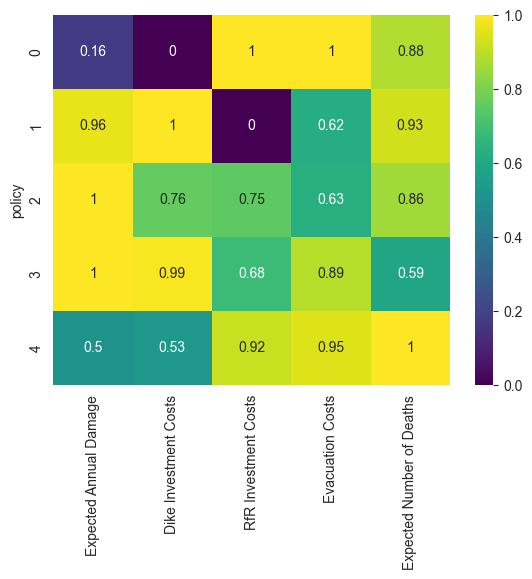

In [12]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [13]:
max_regret

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy,,,,,
0,2.920225e+08,0.000000e+00,363800000.0,23100.567869,0.195621
1,1.710144e+09,1.997962e+08,0.0,14270.143157,0.206282
2,1.772835e+09,1.518136e+08,273300000.0,14586.968589,0.190598
3,1.769864e+09,1.981846e+08,248500000.0,20488.311857,0.131017
4,8.948345e+08,1.062546e+08,333100000.0,21847.849394,0.221994


The heatmap above illustrates the relation between the policies and the objectives in terms of maximum regret. As mentioned before the favored results are as low as possible meaning that the maximum regret for a policy is little.

From this image it is visible that policy 3 performs relatively well on the Expected number of deaths by having the lowest Maximum Regret value. However, it scores the worst on the objectives Expected annual damage and Dike investment costs. In general policy 3 scores the worst on the Maximum Regret metric while it had the best Signal-to-noise ratio results.
What is interesting to see is that policy 0 in total has the lowest Maximum regret scores. This indicates that the robustness level is high. This is contradicting to the Signal-to-noise ratio values where policy 0 scores the worst.

It has to be said that in general the Maximum regret metric is more sensitive. This means that the value can quickly become large whenever there is an extreme high value for a policy. For this reason the Signal-to-noise ratio performs as a better indicator for the level of robustness.